In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.2 MB/s eta 0:00:00


In [4]:
import py7zr

archive_path = '../input/cifar-10/train.7z'
extract_folder = '/kaggle/temp/'

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_folder)

train_labels = pd.read_csv("../input/cifar-10/trainLabels.csv", header="infer")

In [5]:
parent_path_train = "/kaggle/temp/train"
parent_path_valid = "/kaggle/temp/valid"

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for class1 in classes:
    path_train = os.path.join(parent_path_train, class1)
    os.makedirs(path_train, exist_ok=True)  # This will create directories if they don't exist
    
    path_valid = os.path.join(parent_path_valid, class1)
    os.makedirs(path_valid, exist_ok=True)  # This will create directories if they don't exist

for (int_ind, row) in train_labels.iterrows():
    id = str(row["id"]) + ".png"
    source_path = os.path.join(parent_path_train, id)
    
    if not os.path.exists(source_path):
        print(f"Missing source file: {source_path}")
        continue
    
    p = np.random.random()
    if p <= 0.8:
        target_path = os.path.join(parent_path_train, row["label"], id)
    else:
        target_path = os.path.join(parent_path_valid, row["label"], id)
    
    os.replace(source_path, target_path)

print("Processing completed!")


Processing completed!


In [6]:
classes = train_labels['label'].unique()
parent_path_train = "/kaggle/temp/train"
parent_path_valid = "/kaggle/temp/valid"
dls=ImageDataLoaders.from_folder(path='/kaggle/temp',
                            train='train', valid='valid',item_tfms=Resize(224),bs=64)

In [7]:
os.listdir('/kaggle/temp')

['valid', 'train']

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f

epoch,train_loss,valid_loss,accuracy,time
0,0.361632,0.227418,0.925226,06:16
1,0.202388,0.149157,0.948394,06:16
2,0.116264,0.114659,0.962315,06:17
3,0.052834,0.110161,0.964303,06:16
4,0.035643,0.110585,0.964502,06:16


epoch,train_loss,valid_loss,accuracy,time
0,0.032952,0.108636,0.966392,08:19
1,0.034976,0.114047,0.964999,08:18
2,0.025091,0.125958,0.963011,08:18
3,0.018835,0.130009,0.964900,08:18
4,0.011125,0.121697,0.967784,08:18
5,0.007189,0.124357,0.966889,08:17
6,0.003976,0.124581,0.967485,08:18
7,0.002654,0.120475,0.968181,08:18
8,0.001707,0.120405,0.967982,08:18
9,0.001449,0.120594,0.968281,08:18


epoch,train_loss,valid_loss,accuracy,time
0,0.407376,0.233566,0.924729,05:44
1,0.214541,0.132890,0.954658,05:43
2,0.154327,0.099849,0.965894,05:42
3,0.112255,0.090617,0.969772,05:42
4,0.107027,0.088526,0.970667,05:42


epoch,train_loss,valid_loss,accuracy,time
0,0.090449,0.092496,0.968977,07:36
1,0.097584,0.085722,0.972159,07:37
2,0.075619,0.081032,0.973054,07:36
3,0.054397,0.080632,0.974645,07:36
4,0.045017,0.078212,0.974346,07:37
5,0.031973,0.077830,0.976136,07:37
6,0.024757,0.077871,0.975937,07:37
7,0.017926,0.073213,0.977926,07:37
8,0.019267,0.072807,0.978324,07:37
9,0.016416,0.072510,0.977528,07:37


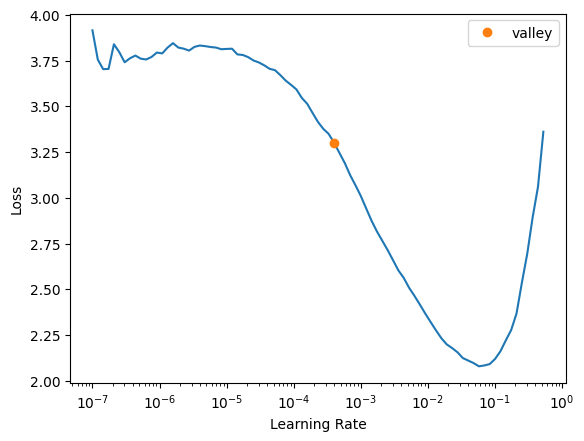

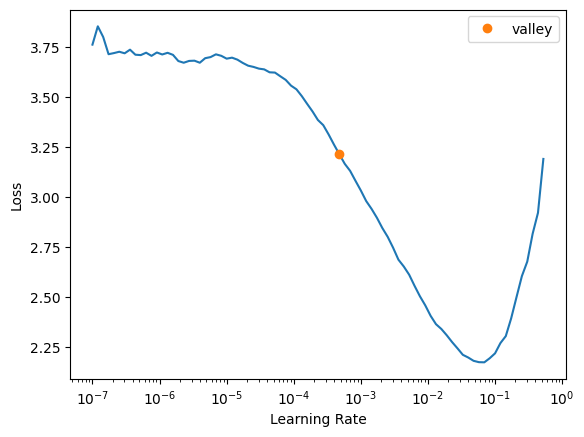

In [8]:
learn = cnn_learner(dls, resnet152, metrics=accuracy)
learn.lr_find()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-3))

learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

dls = ImageDataLoaders.from_folder(path='/kaggle/temp',
                                   train='train', valid='valid', item_tfms=Resize(224), bs=64,
                                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
learn = cnn_learner(dls, resnet152, metrics=accuracy).to_fp16()

learn.lr_find()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-3))

learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

In [9]:
archive_path = '/kaggle/input/cifar-10/test.7z'
extract_folder = '/kaggle/temp/test/'

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_folder)


In [10]:
learn.save('/kaggle/working/vision')

Path('/kaggle/working/vision.pth')

In [11]:
len(os.listdir('/kaggle/temp/test/test'))
path='/kaggle/temp/test/test'
f=os.listdir(path)
new=[str(path)+'/'+s for s in f]

In [12]:
test_dl=learn.dls.test_dl(new)
class_score,y=learn.get_preds(dl=test_dl)
class_score = np.argmax(class_score, axis=1)

class_score[1].item()
classScore=class_score.tolist()
learn.dls.vocab
classes={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
predicted_classes=np.empty(shape=300000,dtype=np.dtype('U20'))

In [13]:
ind=0
for i in (classScore):
    predicted_classes[ind]=classes[i]
    ind=ind+1

In [14]:
directory = '/kaggle/temp/test/test'
ImageId = [ (''.join(filter(str.isdigit, name ))) for name in os.listdir(directory)]

In [15]:
submission  = pd.DataFrame({
    "id": ImageId,
    "label": predicted_classes
})
submission.to_csv("submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))
submission['id']=submission['id'].astype(int)
submission.to_csv('submission.csv', index=False)

,id,label
0,287200,automobile
1,33557,cat
2,281872,deer


,id,label
299997,253814,truck
299998,17297,dog
299999,259315,deer
